MIE1622 - Assignment #3

Credit Risk Modeling and Simulation

Alexander Cheng - 1001634298

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
from scipy.linalg import cholesky
from pathlib import Path
import math
import scipy.stats as scs
import matplotlib.pyplot as plt

In [ ]:
# Set seed so numbers don't change every run

np.random.seed(1)

In [ ]:
Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic
C = 8          # number of credit states

# Read and parse instrument data
# This is a 100x22 column
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns
K = instr_data.shape[0]         # number of CPs

From Group 11 Presentation:

Transform Uncorrelated Normal Random Variable Into Correlated Normal Random Variable

Cholesky decomposition is a method to generate correlated random numbers with specific correlation structures from uncorrelated random numbers by the following 2  steps:


1.   Decompose the desired covariance matrix into product of a lower triangular matrix (L) and its transpose (LT) using the Cholesky factorization.
2.   Multiply the generated independent Normal random variables by the lower triangular matrix (L) to obtain a set of correlated Gaussian random variables.

**The formula:**

$cov = L * L^T$

$y = L* X$

Where:


*   $cov$ is the desired covariance matrix you want to generate
*   $L$ is the lower triangular matrix of $cov$
*   $X$ is the unprocessed data
*   $y$ is the transformed correlated normally distributed random variable

In [ ]:
# L = np.linalg.cholesky(cov)

In [ ]:
# Read matrix of correlations for credit drivers
# This is a 50x50 matrix with correlations between each other
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
M = len(rho)
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho) # Lower diagonal matrix that correlates with each other
upper_chol = cholesky(rho) # Upper

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


In [ ]:
# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1 # Current bond is the bond with the highest probability

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
# scipy.special.ndtri is used to return the argument x for which the area under the Gaussian probability density function is equal to y.
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

In [ ]:
# -------- Insert your code here -------- #
filename_save_out = 'scen_out'
if Path(filename_save_out+'.npz').is_file():
    Losses_out = scipy.sparse.load_npz(filename_save_out + '.npz')
else:
  # Generating Scenarios - True Distribution

  # -------- Insert your code here -------- #
  rnd_y_out = np.random.normal(0.0, 1.0, size=(Nout, M))
  y_out = np.dot(rnd_y_out, upper_chol) # Correlated Systematic Risk between normal and correlation
  z_out = np.random.normal(0.0, 1.0, size=(Nout, 1))
  w_out = np.zeros((Nout, K))
  Losses_out = np.zeros((Nout, K))

  for s in range(Nout):
      # -------- Insert your code here -------- #

      # Calculated out-of-sample losses (100000 x 100)
      for i in range(K):
        # Calculated the creditworthiness index (W), 2 Portfolios, 50 Credit drivers (y-sub-jk)
        w_out[s][i] = beta[i]*y_out[s][int(driver[i]-1)]+np.sqrt(1-beta[i]**2)*z_out[s]
        credit_state_index = 0

        # Determine bond transition state
        for j in range(1,8):
          if (CS_Bdry[i][j-1] < w_out[s][i]):
            credit_state_index = credit_state_index + 1
        # Losses_out (sparse matrix)
        Losses_out [s][i] = exposure[i][credit_state_index]

  np.savetxt(filename_save_out + '.csv',Losses_out)        

In [ ]:
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out, rowvar=False) # Losses_out as a sparse matrix

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

# Portfolio 1: 1 unit in each
# Portoflio 2: Equal value in $ in each of the 100 bonds

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

In [ ]:
Total_loss_out = {}
Total_loss_out_sort = {}

# Normal approximation computed from out-of-sample scenarios for both portfolios
# Out of sample represents true distribution
# Want to calculate model error between calculation and assumed normal distribution

for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q] # Alpha values
        # -------- Insert your code here -------- #
        Total_loss_out[portN] = np.dot(Losses_out, x0[portN])
        Total_loss_out_sort[portN] = np.sort(Total_loss_out[portN])

        VaRout[portN, q] = Total_loss_out_sort[portN][int(math.ceil(Nout * alf)) - 1]
        VaRinN[portN, q] = np.mean(Total_loss_out_sort[portN]) + scs.norm.ppf(alf) * np.std(Total_loss_out_sort[portN]) # Normal 1 year VaR
        CVaRout[portN, q] = (1/(Nout*(1-alf))) * ((math.ceil(Nout*alf) - Nout*alf)*VaRout[portN, q] + sum(Total_loss_out_sort[portN][int(math.ceil(Nout*alf)):]))
        CVaRinN[portN, q] = np.mean(Total_loss_out_sort[portN]) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1-alf)) * np.std(Total_loss_out_sort[portN]) # Normal 1 year CVaR

In [ ]:
# Cases: MC1, N1, MC2, N2
# Find VaR and CVaR for all cases
# As well as two portfolios for each case
# Two Monte Carlo simulations are used to calculate sampling error

N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)

# Perform 100 trials
for tr in range(1, N_trials + 1):

    # Monte Carlo approximation 1

    # -------- Insert your code here -------- #
    
    rnd_y_MC1 = np.random.normal(0.0, 1.0, size=(int(Nin/Ns), M))
    y_MC1 = np.dot(rnd_y_MC1, upper_chol) # Correlated Systematic Risk
    z_MC1 = np.random.normal(0.0, 1.0, size=(Nin, 1))
    w_MC1 = np.zeros((Nin, K))
    Losses_inMC1 = np.zeros((Nin, K))

    for s in range(1, np.int32(np.ceil(Nin / Ns) + 1)): # systemic scenarios
        # -------- Insert your code here -------- #

        for i in range(Ns): # idiosyncratic scenarios for each systemic
            # -------- Insert your code here -------- #

            for j in range(K): # 50 Credit drivers

              z = int(Ns*(s-1)+i) # Seperate into 5 1000 sliced data

              w_MC1[z][j] = beta[j]*y_MC1[s-1][int(driver[j]-1)]+np.sqrt(1-beta[j]**2)*z_MC1[z]
              credit_state_index = 0

              # Determine bond transition state
              for k in range(1,8):
                if (CS_Bdry[j][k-1] < w_MC1[z][j]):
                  credit_state_index = credit_state_index + 1

              # Calculate losses for MC1 approximation (5000 x 100)
              # Losses_inMC1
              Losses_inMC1[z][j] = exposure[j][credit_state_index]

    # Monte Carlo approximation 2

    # -------- Insert your code here -------- #

    rnd_y_MC2 = np.random.normal(0.0, 1.0, size=(Nin, M))
    y_MC2 = np.dot(rnd_y_MC2, upper_chol) # Correlated Systematic Risk
    z_MC2 = np.random.normal(0.0, 1.0, size=(Nin, 1))
    w_MC2 = np.zeros((Nin, K))
    Losses_inMC2 = np.zeros((Nin, K))

    for s in range(1, Nin + 1): # systemic scenarios (1 idiosyncratic scenario for each systemic)
        # -------- Insert your code here -------- #
        for i in range(K):
          w_MC2[s-1][i] = beta[i]*y_MC2[s-1][int(driver[i]-1)]+np.sqrt(1-beta[i]**2)*z_MC2[s-1]
          credit_state_index = 0
          
          # Determine bond transition state
          for j in range(1,8):
            if (CS_Bdry[i][j-1] < w_MC2[s-1][i]):
              credit_state_index = credit_state_index + 1

          # Calculated losses for MC2 approximation (5000 x 100)
          # Losses_inMC2
          Losses_inMC2[s-1][i] = exposure[i][credit_state_index]

    # Compute VaR and CVaR

    portf_loss_inMC1 = {}
    portf_loss_inMC2 = {}

    # Calculate for each alpha and for each portfolio
    for portN in range(2):
        for q in range(alphas.size):
          alf = alphas[q]
          # -------- Insert your code here -------- #
          # Compute portfolio loss
          portf_loss_inMC1[portN] = np.sort(np.dot(Losses_inMC1, x0[portN]))
          portf_loss_inMC2[portN] = np.sort(np.dot(Losses_inMC2, x0[portN]))

          mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
          var_MC1 = np.cov(Losses_inMC1, rowvar=False)
          mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
          var_MC2 = np.cov(Losses_inMC2, rowvar=False)

          # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
          # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
          # Compute VaR and CVaR for the current trial

          mu_p_MC1 = np.mean(portf_loss_inMC1[portN])
          sigma_p_MC1 = np.std(portf_loss_inMC1[portN])
          mu_p_MC2 = np.mean(portf_loss_inMC2[portN])
          sigma_p_MC2 = np.std(portf_loss_inMC2[portN])

          VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[portN][int(math.ceil(Nin * alf)) - 1]
          VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[portN][int(math.ceil(Nin * alf)) - 1]
          VaRinN1[portN, q][tr - 1] =  mu_p_MC1  + scs.norm.ppf(alf) * sigma_p_MC1 # Normal 1 year VaR
          VaRinN2[portN, q][tr - 1] =  mu_p_MC2  + scs.norm.ppf(alf) * sigma_p_MC2 # Normal 1 year VaR
          CVaRinMC1[portN, q][tr - 1] = (1/(Nin*(1-alf))) * ((math.ceil(Nin*alf) - Nin*alf)*VaRinMC1[portN, q][tr-1] + sum(portf_loss_inMC1[portN][int(math.ceil(Nin*alf)):]))
          CVaRinMC2[portN, q][tr - 1] = (1/(Nin*(1-alf))) * ((math.ceil(Nin*alf) - Nin*alf)*VaRinMC2[portN, q][tr-1] + sum(portf_loss_inMC2[portN][int(math.ceil(Nin*alf)):]))
          CVaRinN1[portN, q][tr - 1] =  mu_p_MC1 + (scs.norm.pdf(scs.norm.ppf(alf)) /(1-alf))* sigma_p_MC1 # Normal 1 year VaR
          CVaRinN2[portN, q][tr - 1] =  mu_p_MC2 + (scs.norm.pdf(scs.norm.ppf(alf)) /(1-alf))* sigma_p_MC2 # Normal 1 year VaR

In [ ]:
# Display VaR and CVaR

for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))


Portfolio 1:

Out-of-sample: VaR 99.0% = $82696853.28, CVaR 99.0% = $123389989.06
In-sample MC1: VaR 99.0% = $84168413.52, CVaR 99.0% = $124234846.56
In-sample MC2: VaR 99.0% = $85050766.71, CVaR 99.0% = $125489858.78
In-sample No: VaR 99.0% = $46366497.88, CVaR 99.0% = $52204462.00
In-sample N1: VaR 99.0% = $46840656.05, CVaR 99.0% = $52739514.74
In-sample N2: VaR 99.0% = $47256573.09, CVaR 99.0% = $53208982.55

Out-of-sample: VaR 99.9% = $174144664.76, CVaR 99.9% = $212730444.31
In-sample MC1: VaR 99.9% = $175382157.59, CVaR 99.9% = $217105880.96
In-sample MC2: VaR 99.9% = $176110425.39, CVaR 99.9% = $215929958.52
In-sample No: VaR 99.9% = $59526641.86, CVaR 99.9% = $64296326.87
In-sample N1: VaR 99.9% = $60138070.70, CVaR 99.9% = $64957507.29
In-sample N2: VaR 99.9% = $60674703.77, CVaR 99.9% = $65537891.96


Portfolio 2:

Out-of-sample: VaR 99.0% = $73348811.38, CVaR 99.0% = $116266854.05
In-sample MC1: VaR 99.0% = $74753668.62, CVaR 99.0% = $116767847.31
In-sample MC2: VaR 99.0% 

In [ ]:
# Plot results (6 plots, 2 portfolios & 3 scenarios)
# Figure (1):
# -------- Insert your code here -------- #
# Figure (2):
# -------- Insert your code here -------- #

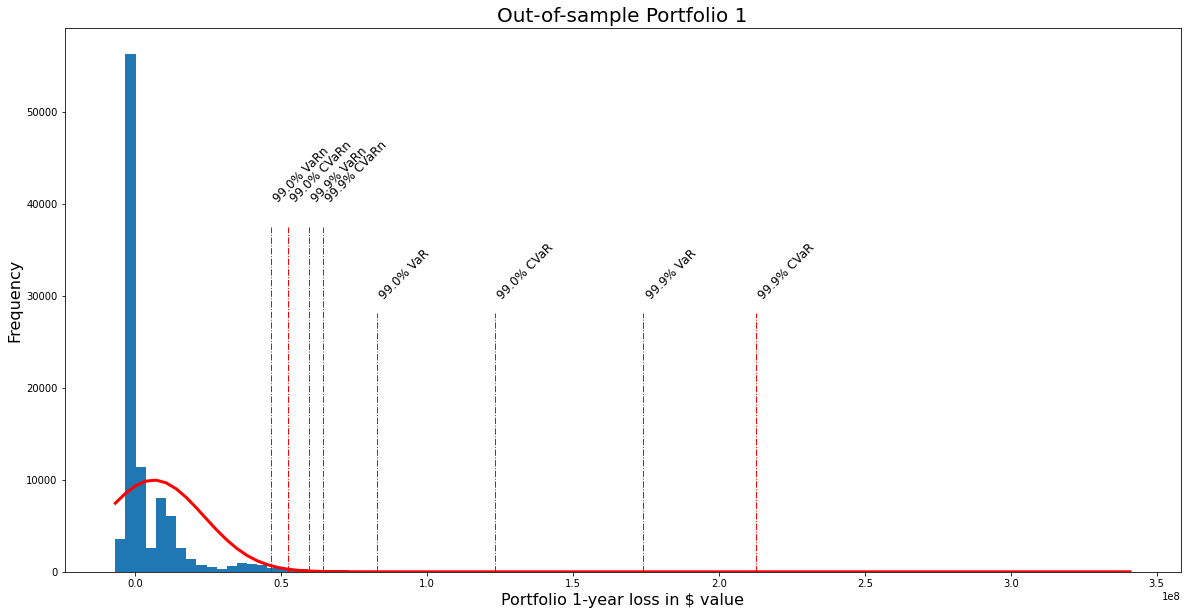

In [ ]:
# Out-of-sample Portfolio 1

fig = plt.figure(figsize=(20,10))
portf = 0
sigma = np.std(Total_loss_out_sort[portf])
mu = np.mean(Total_loss_out_sort[portf])
frequencyCounts, binLocations, patches = plt.hist(Total_loss_out_sort[portf], 100)
normf = (1 / sigma * math.sqrt(2 * math.pi)) * np.exp(-0.5 * ((binLocations - mu) / sigma) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, linewidth=3.0, color='r')

for q in range(alphas.size):
  alf = alphas[q]
  if alf == 0.99:
    i = 0
  else: # alf = 0.999
    i = 1

  plt.plot([VaRout[portf,i], VaRout[portf,i]], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')
  plt.plot([VaRinN[portf,i], VaRinN[portf,i]], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
  plt.plot([CVaRout[portf,i], CVaRout[portf,i]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
  plt.plot([CVaRinN[portf,i], CVaRinN[portf,i]], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')

  plt.text(VaRout[portf,i], max(frequencyCounts) / 1.9, '%4.1f%% VaR' % (100 * alf), fontsize=12, rotation = 45)
  plt.text(VaRinN[portf,i], max(frequencyCounts) / 1.4, '%4.1f%% VaRn' % (100 * alf), fontsize=12, rotation = 45)
  plt.text(CVaRout[portf,i], max(frequencyCounts) / 1.9, '%4.1f%% CVaR' % (100 * alf), fontsize=12, rotation = 45)
  plt.text(CVaRinN[portf,i], max(frequencyCounts) / 1.4, '%4.1f%% CVaRn' % (100 * alf), fontsize=12, rotation = 45)

plt.title('Out-of-sample Portfolio 1',fontsize=20)
plt.xlabel('Portfolio 1-year loss in $ value',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.draw()

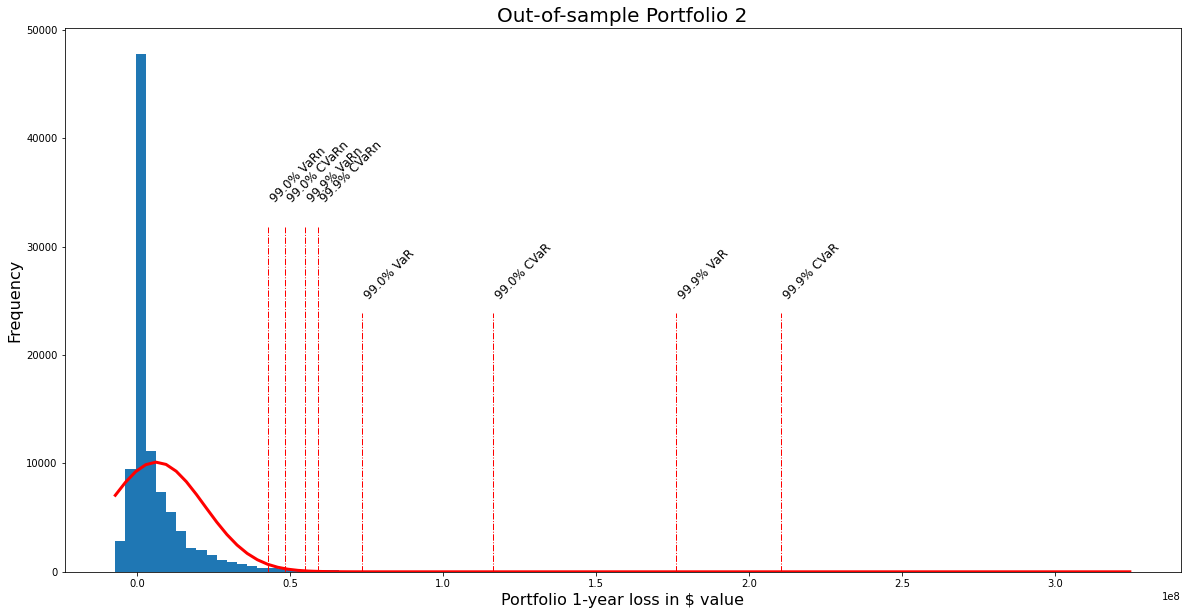

In [ ]:
# Out-of-sample Portfolio 2

fig = plt.figure(figsize=(20,10))
portf = 1
sigma = np.std(Total_loss_out_sort[portf])
mu = np.mean(Total_loss_out_sort[portf])
frequencyCounts, binLocations, patches = plt.hist(Total_loss_out_sort[portf], 100)
normf = (1 / sigma * math.sqrt(2 * math.pi)) * np.exp(-0.5 * ((binLocations - mu) / sigma) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, linewidth=3.0, color='r')

for q in range(alphas.size):
  alf = alphas[q]
  if alf == 0.99:
    i = 0
  else:
    i = 1

  plt.plot([VaRout[portf,i], VaRout[portf,i]], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')
  plt.plot([VaRinN[portf,i], VaRinN[portf,i]], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
  plt.plot([CVaRout[portf,i], CVaRout[portf,i]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
  plt.plot([CVaRinN[portf,i], CVaRinN[portf,i]], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')

  plt.text(VaRout[portf,i], max(frequencyCounts) / 1.9, '%4.1f%% VaR' % (100 * alf), fontsize=12, rotation = 45)
  plt.text(VaRinN[portf,i], max(frequencyCounts) / 1.4, '%4.1f%% VaRn' % (100 * alf), fontsize=12, rotation = 45)
  plt.text(CVaRout[portf,i], max(frequencyCounts) / 1.9, '%4.1f%% CVaR' % (100 * alf), fontsize=12, rotation = 45)
  plt.text(CVaRinN[portf,i], max(frequencyCounts) / 1.4, '%4.1f%% CVaRn' % (100 * alf), fontsize=12, rotation = 45)

plt.title('Out-of-sample Portfolio 2',fontsize=20)
plt.xlabel('Portfolio 1-year loss in $ value',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.draw()

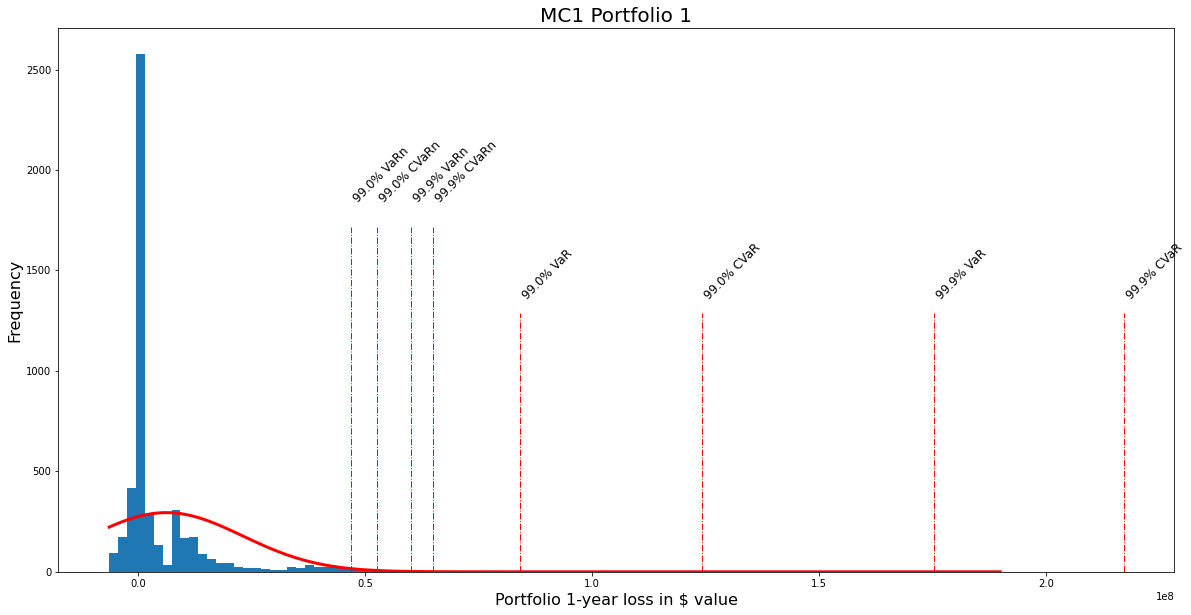

In [ ]:
# MC1 Portfolio 1

fig = plt.figure(figsize=(20,10))
portf = 0
sigma = np.std(portf_loss_inMC1[portf])
mu = np.mean(portf_loss_inMC1[portf])
frequencyCounts, binLocations, patches = plt.hist(portf_loss_inMC1[portf], 100)
normf = (1 / sigma * math.sqrt(2 * math.pi)) * np.exp(-0.5 * ((binLocations - mu) / sigma) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, linewidth=3.0, color='r')

for q in range(alphas.size):
  alf = alphas[q]
  if alf == 0.99:
    i = 0
  else:
    i = 1

  plt.plot([np.mean(VaRinMC1[portf,i]), np.mean(VaRinMC1[portf,i])], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')
  plt.plot([np.mean(VaRinN1[portf,i]), np.mean(VaRinN1[portf,i])], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
  plt.plot([np.mean(CVaRinMC1[portf,i]), np.mean(CVaRinMC1[portf,i])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
  plt.plot([np.mean(CVaRinN1[portf,i]), np.mean(CVaRinN1[portf,i])], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')

  plt.text(np.mean(VaRinMC1[portf,i]), max(frequencyCounts) / 1.9, '%4.1f%% VaR' % (100 * alf), fontsize=12, rotation = 45)
  plt.text(np.mean(VaRinN1[portf,i]), max(frequencyCounts) / 1.4, '%4.1f%% VaRn' % (100 * alf), fontsize=12, rotation = 45)
  plt.text(np.mean(CVaRinMC1[portf,i]), max(frequencyCounts) / 1.9, '%4.1f%% CVaR' % (100 * alf), fontsize=12, rotation = 45)
  plt.text(np.mean(CVaRinN1[portf,i]), max(frequencyCounts) / 1.4, '%4.1f%% CVaRn' % (100 * alf), fontsize=12, rotation = 45)

plt.title('MC1 Portfolio 1',fontsize=20)
plt.xlabel('Portfolio 1-year loss in $ value',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.draw()

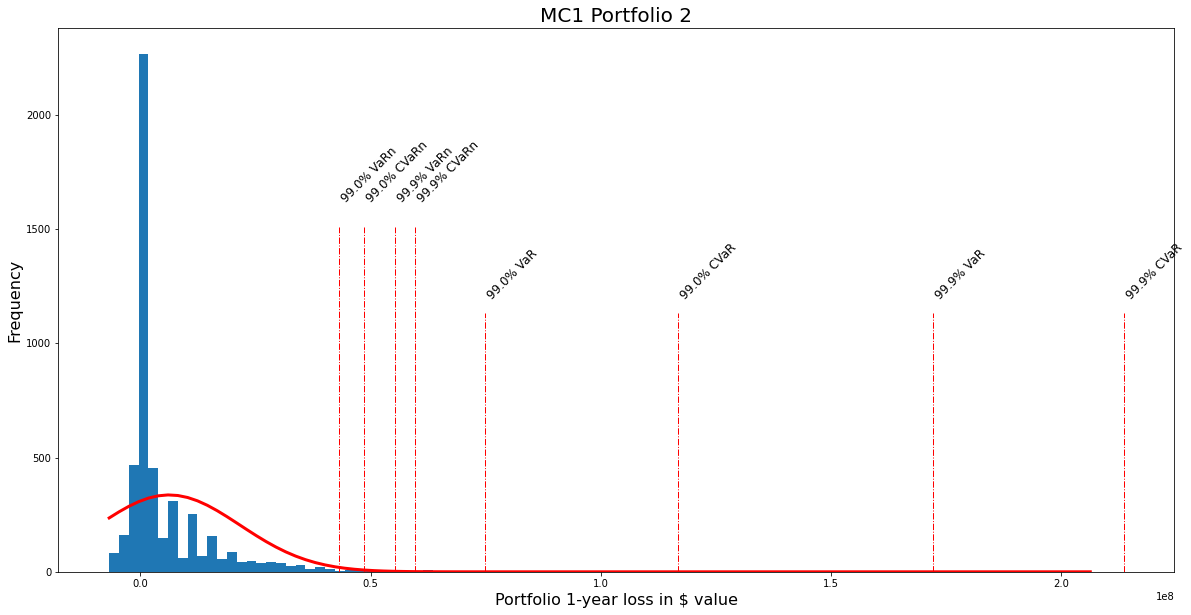

In [ ]:
# MC1 Portfolio 2

fig = plt.figure(figsize=(20,10))
portf = 1
sigma = np.std(portf_loss_inMC1[portf])
mu = np.mean(portf_loss_inMC1[portf])
frequencyCounts, binLocations, patches = plt.hist(portf_loss_inMC1[portf], 100)
normf = (1 / sigma * math.sqrt(2 * math.pi)) * np.exp(-0.5 * ((binLocations - mu) / sigma) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, linewidth=3.0, color='r')

for q in range(alphas.size):
  alf = alphas[q]
  if alf == 0.99:
    i = 0
  else:
    i = 1

  plt.plot([np.mean(VaRinMC1[portf,i]), np.mean(VaRinMC1[portf,i])], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')
  plt.plot([np.mean(VaRinN1[portf,i]), np.mean(VaRinN1[portf,i])], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
  plt.plot([np.mean(CVaRinMC1[portf,i]), np.mean(CVaRinMC1[portf,i])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
  plt.plot([np.mean(CVaRinN1[portf,i]), np.mean(CVaRinN1[portf,i])], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')

  plt.text(np.mean(VaRinMC1[portf,i]), max(frequencyCounts) / 1.9, '%4.1f%% VaR' % (100 * alf), fontsize=12, rotation = 45)
  plt.text(np.mean(VaRinN1[portf,i]), max(frequencyCounts) / 1.4, '%4.1f%% VaRn' % (100 * alf), fontsize=12, rotation = 45)
  plt.text(np.mean(CVaRinMC1[portf,i]), max(frequencyCounts) / 1.9, '%4.1f%% CVaR' % (100 * alf), fontsize=12, rotation = 45)
  plt.text(np.mean(CVaRinN1[portf,i]), max(frequencyCounts) / 1.4, '%4.1f%% CVaRn' % (100 * alf), fontsize=12, rotation = 45)

plt.title('MC1 Portfolio 2',fontsize=20)
plt.xlabel('Portfolio 1-year loss in $ value',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.draw()

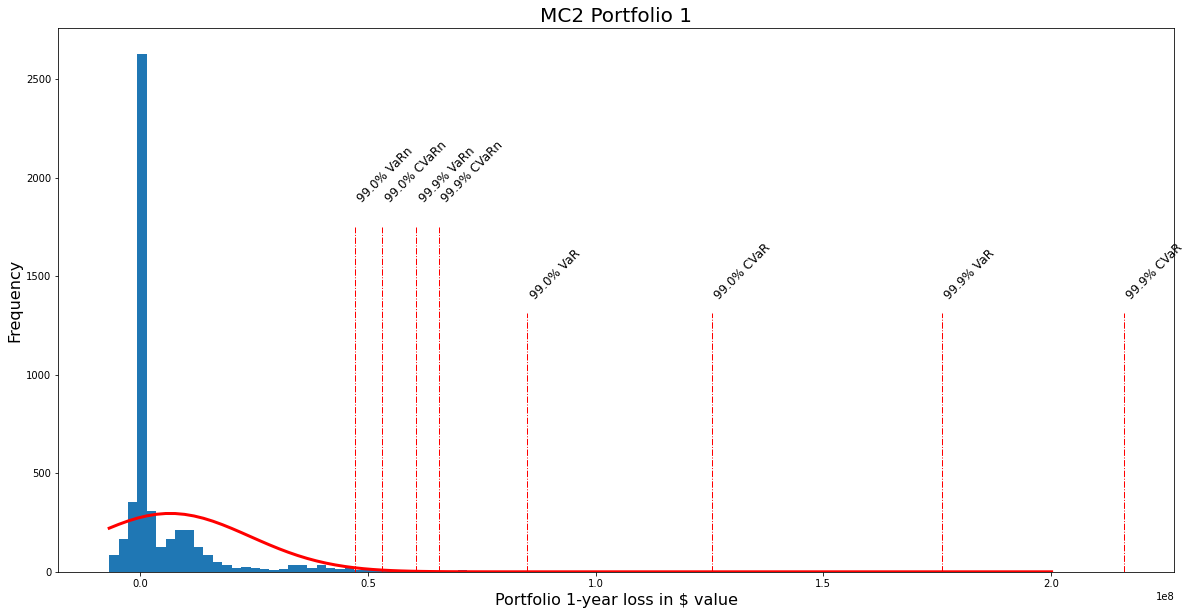

In [ ]:
# MC2 Portfolio 1

fig = plt.figure(figsize=(20,10))
portf = 0
sigma = np.std(portf_loss_inMC2[portf])
mu = np.mean(portf_loss_inMC2[portf])
frequencyCounts, binLocations, patches = plt.hist(portf_loss_inMC2[portf], 100)
normf = (1 / sigma * math.sqrt(2 * math.pi)) * np.exp(-0.5 * ((binLocations - mu) / sigma) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, linewidth=3.0, color='r')

for q in range(alphas.size):
  alf = alphas[q]
  if alf == 0.99:
    i = 0
  else:
    i = 1

  plt.plot([np.mean(VaRinMC2[portf,i]), np.mean(VaRinMC2[portf,i])], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')
  plt.plot([np.mean(VaRinN2[portf,i]), np.mean(VaRinN2[portf,i])], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
  plt.plot([np.mean(CVaRinMC2[portf,i]), np.mean(CVaRinMC2[portf,i])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
  plt.plot([np.mean(CVaRinN2[portf,i]), np.mean(CVaRinN2[portf,i])], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')

  plt.text(np.mean(VaRinMC2[portf,i]), max(frequencyCounts) / 1.9, '%4.1f%% VaR' % (100 * alf), fontsize=12, rotation = 45)
  plt.text(np.mean(VaRinN2[portf,i]), max(frequencyCounts) / 1.4, '%4.1f%% VaRn' % (100 * alf), fontsize=12, rotation = 45)
  plt.text(np.mean(CVaRinMC2[portf,i]), max(frequencyCounts) / 1.9, '%4.1f%% CVaR' % (100 * alf), fontsize=12, rotation = 45)
  plt.text(np.mean(CVaRinN2[portf,i]), max(frequencyCounts) / 1.4, '%4.1f%% CVaRn' % (100 * alf), fontsize=12, rotation = 45)

plt.title('MC2 Portfolio 1',fontsize=20)
plt.xlabel('Portfolio 1-year loss in $ value',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.draw()

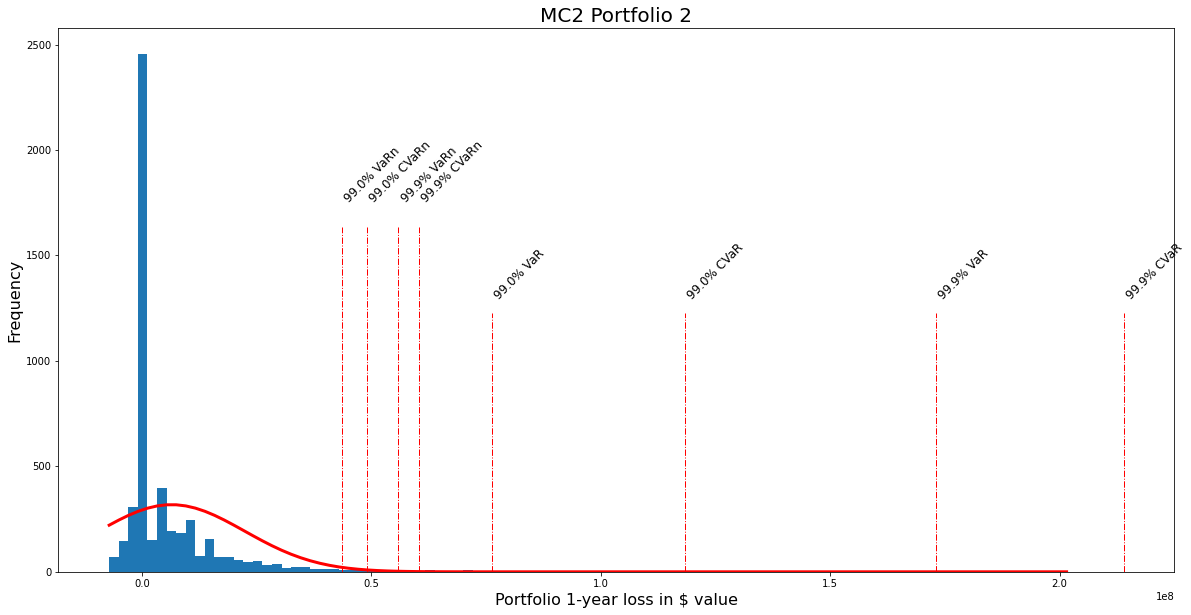

In [ ]:
# MC2 Portfolio 2

fig = plt.figure(figsize=(20,10))
portf = 1
sigma = np.std(portf_loss_inMC2[portf])
mu = np.mean(portf_loss_inMC2[portf])
frequencyCounts, binLocations, patches = plt.hist(portf_loss_inMC2[portf], 100)
normf = (1 / sigma * math.sqrt(2 * math.pi)) * np.exp(-0.5 * ((binLocations - mu) / sigma) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, linewidth=3.0, color='r')

for q in range(alphas.size):
  alf = alphas[q]
  if alf == 0.99:
    i = 0
  else:
    i = 1

  plt.plot([np.mean(VaRinMC2[portf,i]), np.mean(VaRinMC2[portf,i])], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')
  plt.plot([np.mean(VaRinN2[portf,i]), np.mean(VaRinN2[portf,i])], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
  plt.plot([np.mean(CVaRinMC2[portf,i]), np.mean(CVaRinMC2[portf,i])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
  plt.plot([np.mean(CVaRinN2[portf,i]), np.mean(CVaRinN2[portf,i])], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')

  plt.text(np.mean(VaRinMC2[portf,i]), max(frequencyCounts) / 1.9, '%4.1f%% VaR' % (100 * alf), fontsize=12, rotation = 45)
  plt.text(np.mean(VaRinN2[portf,i]), max(frequencyCounts) / 1.4, '%4.1f%% VaRn' % (100 * alf), fontsize=12, rotation = 45)
  plt.text(np.mean(CVaRinMC2[portf,i]), max(frequencyCounts) / 1.9, '%4.1f%% CVaR' % (100 * alf), fontsize=12, rotation = 45)
  plt.text(np.mean(CVaRinN2[portf,i]), max(frequencyCounts) / 1.4, '%4.1f%% CVaRn' % (100 * alf), fontsize=12, rotation = 45)

plt.title('MC2 Portfolio 2',fontsize=20)
plt.xlabel('Portfolio 1-year loss in $ value',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.draw()

In [ ]:
# Build tables for errors
# MC approximations (16 rows)
df_mc = pd.DataFrame({})
# -------- Insert your code here -------- #

Case = []
loss_list = []
sample_error = []
true_value = []

for portN in range(2):
    for q in range(alphas.size):
        alf = alphas[q]

        Case.append('%4.1f%% MC1 VaR (Portfolio %1.0f)'  % (100 * alf, (portN + 1)))
        Case.append('%4.1f%% MC1 CVaR (Portfolio %1.0f)'  % (100 * alf, (portN + 1)))
        Case.append('%4.1f%% MC2 VaR (Portfolio %1.0f)'  % (100 * alf, (portN + 1)))
        Case.append('%4.1f%% MC2 CVaR (Portfolio %1.0f)'  % (100 * alf, (portN + 1)))

        loss_list.append(np.mean(VaRinMC1[portN, q]))
        loss_list.append(np.mean(CVaRinMC1[portN, q]))
        loss_list.append(np.mean(VaRinMC2[portN, q]))
        loss_list.append(np.mean(CVaRinMC2[portN, q]))

        true_value.append(VaRout[portN, q])
        true_value.append(CVaRout[portN, q])
        true_value.append(VaRout[portN, q])
        true_value.append(CVaRout[portN, q])

        sample_error.append((np.mean(VaRinMC1[portN, q]) - VaRout[portN, q]) / VaRout[portN, q]*100)
        sample_error.append((np.mean(CVaRinMC1[portN, q]) - CVaRout[portN, q]) / CVaRout[portN, q]*100)
        sample_error.append((np.mean(VaRinMC2[portN, q]) - VaRout[portN, q]) / VaRout[portN, q]*100)
        sample_error.append((np.mean(CVaRinMC2[portN, q]) - CVaRout[portN, q]) / CVaRout[portN, q]*100)

df_mc['Case'] = Case
df_mc['Loss ($)'] = loss_list
df_mc['True Value ($)'] = true_value
df_mc['Error (%)'] = sample_error


# -------- Insert your code here -------- #
# Normal approximations (16 rows)
df_N = pd.DataFrame({})

Norm_Case = []
Norm_loss_list = []
model_error = []

for portN in range(2):
    for q in range(alphas.size):
        alf = alphas[q]

        Norm_Case.append('%4.1f%% N1 VaR (Portfolio %1.0f)'  % (100 * alf, (portN + 1)))
        Norm_Case.append('%4.1f%% N1 CVaR (Portfolio %1.0f)'  % (100 * alf, (portN + 1)))
        Norm_Case.append('%4.1f%% N2 VaR (Portfolio %1.0f)'  % (100 * alf, (portN + 1)))
        Norm_Case.append('%4.1f%% N2 CVaR (Portfolio %1.0f)'  % (100 * alf, (portN + 1)))

        Norm_loss_list.append(np.mean(VaRinN1[portN, q]))
        Norm_loss_list.append(np.mean(CVaRinN1[portN, q]))
        Norm_loss_list.append(np.mean(VaRinN2[portN, q]))
        Norm_loss_list.append(np.mean(CVaRinN2[portN, q]))

        model_error.append((np.mean(VaRinN1[portN, q]) - VaRout[portN, q]) / VaRout[portN, q]*100)
        model_error.append((np.mean(CVaRinN1[portN, q]) - CVaRout[portN, q]) / CVaRout[portN, q]*100)
        model_error.append((np.mean(VaRinN2[portN, q]) - VaRout[portN, q]) / VaRout[portN, q]*100)
        model_error.append((np.mean(CVaRinN2[portN, q]) - CVaRout[portN, q]) / CVaRout[portN, q]*100)
  
df_N['Case'] = Norm_Case
df_N['Loss ($)'] = Norm_loss_list
df_N['True Value ($)'] = true_value
df_N['Error (%)'] = model_error

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Monte Carlo Sampling Error
df_mc

,Case,Loss ($),True Value ($),Error (%)
0,99.0% MC1 VaR (Portfolio 1),84168413.52,82696853.28,1.78
1,99.0% MC1 CVaR (Portfolio 1),124234846.56,123389989.06,0.68
2,99.0% MC2 VaR (Portfolio 1),85050766.71,82696853.28,2.85
3,99.0% MC2 CVaR (Portfolio 1),125489858.78,123389989.06,1.70
4,99.9% MC1 VaR (Portfolio 1),175382157.59,174144664.76,0.71
5,99.9% MC1 CVaR (Portfolio 1),217105880.96,212730444.31,2.06
6,99.9% MC2 VaR (Portfolio 1),176110425.39,174144664.76,1.13
7,99.9% MC2 CVaR (Portfolio 1),215929958.52,212730444.31,1.50
8,99.0% MC1 VaR (Portfolio 2),74753668.62,73348811.38,1.92
9,99.0% MC1 CVaR (Portfolio 2),116767847.31,116266854.05,0.43


In [ ]:
# Normal Distribution Model Error

df_N

,Case,Loss ($),True Value ($),Error (%)
0,99.0% N1 VaR (Portfolio 1),46840656.05,82696853.28,-43.36
1,99.0% N1 CVaR (Portfolio 1),52739514.74,123389989.06,-57.26
2,99.0% N2 VaR (Portfolio 1),47256573.09,82696853.28,-42.86
3,99.0% N2 CVaR (Portfolio 1),53208982.55,123389989.06,-56.88
4,99.9% N1 VaR (Portfolio 1),60138070.70,174144664.76,-65.47
5,99.9% N1 CVaR (Portfolio 1),64957507.29,212730444.31,-69.46
6,99.9% N2 VaR (Portfolio 1),60674703.77,174144664.76,-65.16
7,99.9% N2 CVaR (Portfolio 1),65537891.96,212730444.31,-69.19
8,99.0% N1 VaR (Portfolio 2),43151429.66,73348811.38,-41.17
9,99.0% N1 CVaR (Portfolio 2),48531521.06,116266854.05,-58.26


In [ ]:
# Used to keep Google Colab Connected

# while True:pass